In [17]:
# Install libraries needed for the project
!pip install flwr tensorflow wfdb

!pip install -U "flwr[simulation]"
!pip install ray[default]

In [2]:
# Import wfdb to check available datasets
import wfdb

# Download MIT-BIH Arrhythmia Database
wfdb.dl_database('mitdb', '/content/mitdb')

# List files to confirm download
!ls /content/mitdb

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [5]:
# Step 3: Preprocess Data
import wfdb
import pandas as pd
import numpy as np

def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    return p_signal, atr_sym, atr_sample

def build_XY(p_signal, df_ann, num_cols, normal):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows, 1))
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max([0, (atr_sample - num_sec * fs)])
        right = min([len(p_signal), (atr_sample + num_sec * fs)])
        x = p_signal[left:right]
        if len(x) == num_cols:
            X[max_row, :] = x
            Y[max_row, :] = int(atr_sym not in normal)
            max_row += 1
    X = X[:max_row, :]
    Y = Y[:max_row, :]
    return X, Y

# Parameters
data = '/content/mitdb/'
num_sec = 1
fs = 360
num_cols = 2 * num_sec * fs
normal = ['N']
abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']
records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
           '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
           '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
           '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
           '222', '223', '228', '230', '231', '232', '233', '234']

def prepare_client_data(record_ids):
    X_all = np.zeros((1, num_cols))
    Y_all = np.zeros((1, 1))
    for pt in record_ids:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        p_signal = p_signal[:, 0]
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(normal + abnormal)]
        X, Y = build_XY(p_signal, df_ann, num_cols, normal)
        X_all = np.append(X_all, X, axis=0)
        Y_all = np.append(Y_all, Y, axis=0)
    X_all = X_all[1:, :]
    Y_all = Y_all[1:, :]
    return X_all, Y_all

# Test data preparation
X_test, Y_test = prepare_client_data(['100'])
print("Shape of X:", X_test.shape)
print("Shape of Y:", Y_test.shape)

# Step 4: Split Data for FL
num_clients = 5
client_records = [records[i::num_clients] for i in range(num_clients)]
client_data = []
for recs in client_records:
    X, Y = prepare_client_data(recs)
    client_data.append((X, Y))
for i, (X, Y) in enumerate(client_data):
    print(f"Client {i+1} - X shape: {X.shape}, Y shape: {Y.shape}")

# Step 5: Define CNN Model
import tensorflow as tf
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(720, 1)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = create_model()
model.summary()

# Step 6: Define FL Client
import flwr as fl
class ECGClient(fl.client.NumPyClient):
    def __init__(self, X, y):
        self.X = X.reshape(-1, 720, 1)
        self.y = y
        self.model = create_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X, self.y, epochs=5, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.X), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X, self.y, verbose=0)
        return loss, len(self.X), {"accuracy": accuracy}

Shape of X: (2270, 720)
Shape of Y: (2270, 1)
Client 1 - X shape: (24595, 720), Y shape: (24595, 1)
Client 2 - X shape: (22976, 720), Y shape: (22976, 1)
Client 3 - X shape: (22357, 720), Y shape: (22357, 1)
Client 4 - X shape: (19705, 720), Y shape: (19705, 1)
Client 5 - X shape: (19708, 720), Y shape: (19708, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 718, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 359, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 357, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 178, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11392)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       729,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,553 (2.81 MB)

 Trainable params: 735,553 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Import Flower simulation and other libraries
import flwr as fl
from flwr.simulation import start_simulation
from flwr.server.client_proxy import ClientProxy
from typing import Dict, Optional, Tuple, List
import numpy as np

# Global variable to store final weights
global_weights = None

# Custom FedAvg strategy to save final weights
class SaveWeightsStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, fl.common.FitRes]],
        failures: List[BaseException]
    ) -> Tuple[Optional[fl.common.Parameters], Dict]:
        # Call parent method to perform aggregation
        aggregated_parameters, metrics = super().aggregate_fit(server_round, results, failures)
        # Save weights in global variable during final round
        if server_round == 10:
            global global_weights
            global_weights = aggregated_parameters
        return aggregated_parameters, metrics

# Define client function for simulation
def client_fn(cid: str) -> fl.client.NumPyClient:
    X, y = client_data[int(cid)]
    return ECGClient(X, y)

# Define strategy
strategy = SaveWeightsStrategy(
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
    evaluate_fn=None,
)

# Run Flower simulation
start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
)

print("Federated Learning Simulation Completed!")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-06-05 08:47:36,871	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7983906816.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3991953408.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActor

Federated Learning Simulation Completed!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.0710, Test Accuracy: 0.9802
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      7491
    Abnormal       0.98      0.96      0.97      3937

    accuracy                           0.98     11428
   macro avg       0.98      0.98      0.98     11428
weighted avg       0.98      0.98      0.98     11428



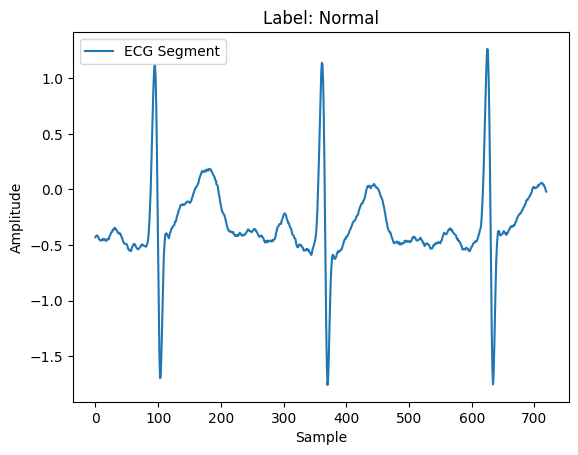

In [7]:
# Import matplotlib and sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Create test set
test_records = ['230', '231', '232', '233', '234']
X_test, Y_test = prepare_client_data(test_records)
X_test = X_test.reshape(-1, 720, 1)  # Corrected shape

# Create model and set global weights
final_model = create_model()
if global_weights is not None:
    weights = fl.common.parameters_to_ndarrays(global_weights)
    final_model.set_weights(weights)
else:
    print("Error: Global weights not saved. Rerun Step 8.")

# Evaluate on test set
loss, accuracy = final_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict and print classification report
predictions = (final_model.predict(X_test) > 0.5).astype(int)
print(classification_report(Y_test, predictions, target_names=['Normal', 'Abnormal']))

# Plot a test segment
plt.plot(X_test[0].reshape(-1), label='ECG Segment')
plt.title(f"Label: {'Normal' if Y_test[0] == 0 else 'Abnormal'}")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()